In [3]:
from __future__ import division, print_function

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ROOT

from root_pandas import read_root, to_root

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.feature_selection import SelectFromModel

from xgboost import XGBClassifier

from tqdm import tqdm
from itertools import islice

from collections import OrderedDict

from scipy.stats import linregress
from uncertainties import ufloat

from scripts.metrics import tagging_power_score
from scripts.calibration import PolynomialLogisticRegression

In [4]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 14

# read and prepare dataset

In [5]:
data_dir = '/home/kheinicke/tank/flavourtagging/'
run_1_filenames = ['Bu2JpsiK_mu-k-e-TrainingTuple_2011_MD_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2011_MU_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2012_MD_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2012_MU_sweighted_kheinick.root',
                   ]
run_2_filenames = ['Bu2JpsiK_mu-k-e-TrainingTuple_2015_MD_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2015_MU_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2016_MD_sweighted_kheinick.root',
                   'Bu2JpsiK_mu-k-e-TrainingTuple_2016_MU_sweighted_kheinick.root',
                   ]
chunksize = 5000
maxslices = None

In [6]:
datasets = OrderedDict([
    ('RUNI', {
        'filenames': [data_dir + f for f in run_1_filenames],
    }),
    ('RUNII', {
        'filenames': [data_dir + f for f in run_2_filenames],
    }),
])

In [7]:
# just define some keyword arguments for read_root in a separate dict
data_kwargs = dict(
    key='DecayTree',  # the tree name
    columns=['B_OS_Muon*',  # all branches that should be read
             'B_ID',
             'B_PT',
             'runNumber',
             'eventNumber',
             'SigYield_sw',
            ],
    chunksize=chunksize,  # this will create a generator, yielding subsets with 'chunksize' of the data
    where='(B_LOKI_MASS_JpsiConstr_NoPVConstr>0)',  # a ROOT where selection, does not work with array-variables
    flatten=True  # will flatten the data in the dimension of the first given column
)

In [8]:
def get_event_number(df, weight_column='SigYield_sw'):
    """ Use weighted sums
    """
    return np.sum(df.groupby('event_id')[weight_column].first())  # max, min, mean, first should give the same values here

In [9]:
# Read datasets and fill several event information
for key, d in datasets.items():
    filenames = d['filenames']
    entries = 0
    for f in filenames:
        rootfile = ROOT.TFile(f)
        tree = rootfile.Get('DecayTree')
        entries += tree.GetEntries()
    datasets[key]['entries'] = entries
    if maxslices is not None and maxslices < entries/chunksize:
        total = maxslices
    else:
        total = entries/chunksize
    df = pd.concat([df for df
                    in tqdm(islice(read_root(filenames, **data_kwargs), maxslices),
                            total=total)])
    df.rename(columns=dict(zip(df.columns, [c.replace('B_OS_Muon', 'tp') for c in df.columns])), inplace=True)
    df['target'] = np.sign(df.B_ID) == np.sign(df.tp_ID)
    df['event_id'] = df.runNumber.apply(str) + '_' + df.eventNumber.apply(str)
    df['tp_ABS_RecVertexIP'] = np.abs(df.tp_RecVertexIP)
    datasets[key]['data'] = df
    datasets[key]['event_number'] = ufloat(get_event_number(df), np.sqrt(get_event_number(df)))

245it [06:40,  1.03s/it]                              
61it [01:05,  1.33it/s]                             


# apply muon-specific selections

In [10]:
# this is the list of BDT variables formerly used
classic_MVA_features = [
    'tp_partP',
    'tp_partPt',
    'tp_IPPU',
    'tp_ghostProb',
    'tp_PIDNNm',
    'tp_ABS_RecVertexIP',
    'tp_mult',
    'tp_ptB',
    'tp_IPs',
]

In [12]:
# define all the classic selections for muon tagger here for a query
queries = [
    'tp_partP > 0',
    'tp_partPt > 1.1',
    'tp_IsSignalDaughter == 0',
    'tp_minPhiDistance > 0.005',
    'tp_MuonPIDIsMuon == 1',
    'tp_partlcs < 3',
    'tp_ABS_RecVertexIP > 0',
    'tp_ghostProb < 0.4',
    'tp_PIDNNm > 0.35',
    'tp_PROBNNpi < 0.8',
    'tp_PROBNNe < 0.8',
    'tp_PROBNNk < 0.8',
    'tp_PROBNNp < 0.8',
    'tp_IPPU > 3',
#    'SigYield_sw > 0'
]

# try to adopt optimized cuts
# queries = [
#     'tp_partP > 3.333333',
#     'tp_partPt > 0.2222222',
#     'tp_IsSignalDaughter == 0',
#     'tp_minPhiDistance > 0',
#     'tp_MuonPIDIsMuon == 1',
#     'tp_partlcs < 3',
#     'tp_ABS_RecVertexIP > 0',
#     'tp_ghostProb < 0.1333333',
#     'tp_PIDNNm > 0.35',
#     'tp_PROBNNpi < 0.8',
#     'tp_PROBNNe < 0.8',
#     'tp_PROBNNk < 0.8',
#     'tp_PROBNNp < 0.8',
#     'tp_IPPU > 4',
#    'SigYield_sw > 0'
# ]
selection_features = [q.split(' ')[0] for q in queries]

In [13]:
# apply query
for key, d in datasets.items():
    df = d['data']
    selected_df = df.query(' and '.join(queries))
    selected_df.reset_index(drop=True, inplace=True)
#     _, bins, _ = plt.hist(df.groupby('event_id')['target'].mean(), alpha=0.5, bins=30)
#     plt.hist(selected_df.groupby('event_id')['target'].mean(), alpha=0.5, bins=bins)
#     plt.show()
#     _, bins, _ = plt.hist(df.groupby('event_id')['target'].count(), alpha=0.5, bins=30)
#     plt.hist(selected_df.groupby('event_id')['target'].count(), alpha=0.5, bins=bins)
#     plt.show()
    max_pt_df = selected_df.iloc[selected_df.groupby('event_id')['tp_partPt'].idxmax()]
    sel_event_number = ufloat(get_event_number(max_pt_df), np.sqrt(get_event_number(max_pt_df)))
    datasets[key]['selected_data'] = selected_df
    datasets[key]['event_number_selected'] = sel_event_number
    datasets[key]['max_pt_data'] = max_pt_df
    event_number = datasets[key]['event_number']
    sel_efficiency = sel_event_number / event_number
    avg_omega = ufloat(np.sum(max_pt_df.SigYield_sw * ~max_pt_df.target) / np.sum(max_pt_df.SigYield_sw),
                       np.sqrt(np.sum(max_pt_df.SigYield_sw * ~max_pt_df.target)) / np.sum(max_pt_df.SigYield_sw))
    avg_tagging_power = sel_efficiency * (1 - 2 * avg_omega)**2
    print('{}:\tε:\t{}% (before {:.0f}, after {:.0f})'.format(key, sel_efficiency * 100, event_number.n, sel_event_number.n))
    print('\t⍵:\t{}%'.format(avg_omega * 100))
    print('\tD2:\t{}%'.format((1 - 2 * avg_omega)**2 * 100))
    print('\tε_eff:\t{}%'.format(avg_tagging_power * 100))

RUNI:	ε:	5.533+/-0.023% (before 1084717, after 60021)
	⍵:	31.31+/-0.23%
	D2:	13.97+/-0.34%
	ε_eff:	0.773+/-0.019%
RUNII:	ε:	7.52+/-0.05% (before 281845, after 21189)
	⍵:	36.4+/-0.4%
	D2:	7.4+/-0.5%
	ε_eff:	0.559+/-0.034%


# train the classifier

In [14]:
for key, d in datasets.items():
    df = d['max_pt_data']
    train_data, _data = train_test_split(df, train_size=0.333, random_state=1)
    test_data, calib_data = train_test_split(_data, train_size=0.5, random_state=1)
    model = XGBClassifier(max_depth=5, n_estimators=400, nthread=24)
#     model = GradientBoostingClassifier()
#     model = RandomForestClassifier(n_estimators=100, n_jobs=24)
    model.fit(train_data[classic_MVA_features], train_data.target)
    model_weighted = XGBClassifier(max_depth=2, n_estimators=300, nthread=24)
    model_weighted.fit(train_data[classic_MVA_features][train_data.SigYield_sw > 0],
                       train_data.target[train_data.SigYield_sw > 0],
                       sample_weight=train_data.SigYield_sw[train_data.SigYield_sw > 0])
    datasets[key]['model'] = model
    datasets[key]['model_weighted'] = model_weighted
    for subset_name in ['train_data', 'test_data', 'calib_data']:
        datasets[key][subset_name] =  locals()[subset_name].copy(deep=True)

RUNI	train_data	auc	85.98%	66.90%
	test_data	auc	58.57%	60.91%
	calib_data	auc	58.57%	61.49%
RUNII	train_data	auc	97.19%	71.23%
	test_data	auc	55.76%	59.24%
	calib_data	auc	55.97%	58.65%


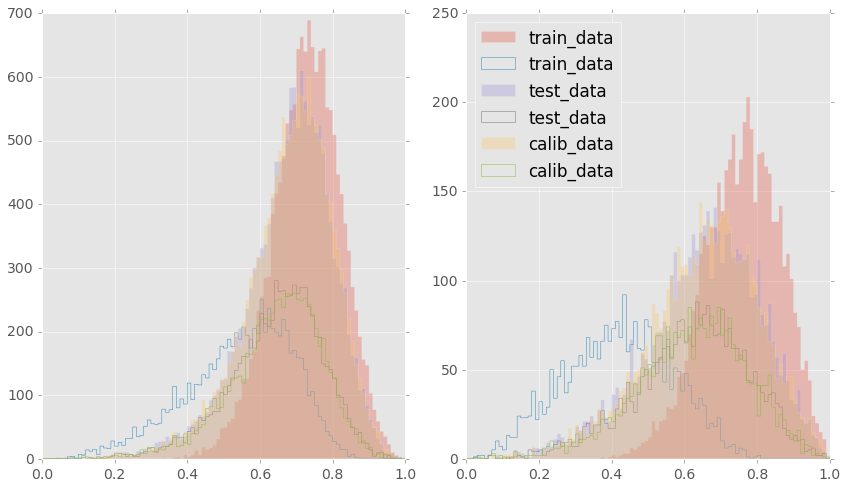

In [22]:
_, (ax1, ax2) = plt.subplots(1, 2)
for (key, d), ax in zip(datasets.items(), (ax1, ax2)):
    plt.axes(ax)
    print(key, end='')
    plt.subplots
    for subset_name in ['train_data', 'test_data', 'calib_data']:
        subset = datasets[key][subset_name]
        subset['probas'] = d['model'].predict_proba(subset[classic_MVA_features])[:,1]
        subset['probas_weighted'] = d['model_weighted'].predict_proba(subset[classic_MVA_features])[:,1]
        subset['prediction'] = subset.probas > 0.5
        subset['prediction_weighted'] = subset.probas_weighted > 0.5
        datasets[key][subset_name] = subset
        auc_score = roc_auc_score(subset.target, subset.probas)
        auc_score_weighted = roc_auc_score(subset.target, subset.probas_weighted, sample_weight=subset.SigYield_sw)
        print('\t{}\tauc\t{:2.2f}%\t{:2.2f}%'.format(subset_name, auc_score * 100, auc_score_weighted * 100))
        plt.hist(subset.probas[subset.target], bins=100, range=(0, 1),
                 alpha=0.3, label=subset_name, histtype='stepfilled')
        plt.hist(subset.probas[~subset.target], bins=100, range=(0, 1),
                 alpha=1.0, label=subset_name, histtype='step')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [16]:
def proba_bins(x, y_true, errs=True, bins=10, range=None, sample_weight=None, auto_fill=False):
    """ Bin data by x and calculate the amount of y_true in each bin,
        errors will be (bin_width/2, sqrt(bin_count))
    """
    if sample_weight is None:
        sample_weight = np.ones(x.shape)

    if auto_fill:
        pass
#         if not isinstance(bins, int):
#             raise ValueError('If auto_fill is True, bins needs to be an integer')
#         bin_content = len(x) / bins
#         bin_edges = [np.min(x)]
#         bins = np.array(bin_edges)
    hist, bin_edges = np.histogram(x, bins=bins, range=range)
    xs = np.array([(x_low + x_high)/2 for x_low, x_high in zip(bin_edges[:-1], bin_edges[1:])])
    true_sums = np.array([np.sum(sample_weight[(x > x_low) & (x <= x_high)])
                          for x_low, x_high in zip(bin_edges[:-1], bin_edges[1:])])
    ys = (np.array([np.sum(sample_weight[(x > x_low) & (x <= x_high) & (np.array(y_true) == True)])
                    for x_low, x_high in zip(bin_edges[:-1], bin_edges[1:])])
          / true_sums)
    if errs:
        y_errs = (np.array([np.sqrt(np.sum(sample_weight[(x > x_low) & (x <= x_high) & (np.array(y_true) == False)]))
                            for x_low, x_high in zip(bin_edges[:-1], bin_edges[1:])])
                  / true_sums)
        x_errs = [(x_high - x_low) / 2 for x_low, x_high in zip(bin_edges[:-1], bin_edges[1:])]
        return xs, ys, y_errs, x_errs
    else:
        return xs, ys

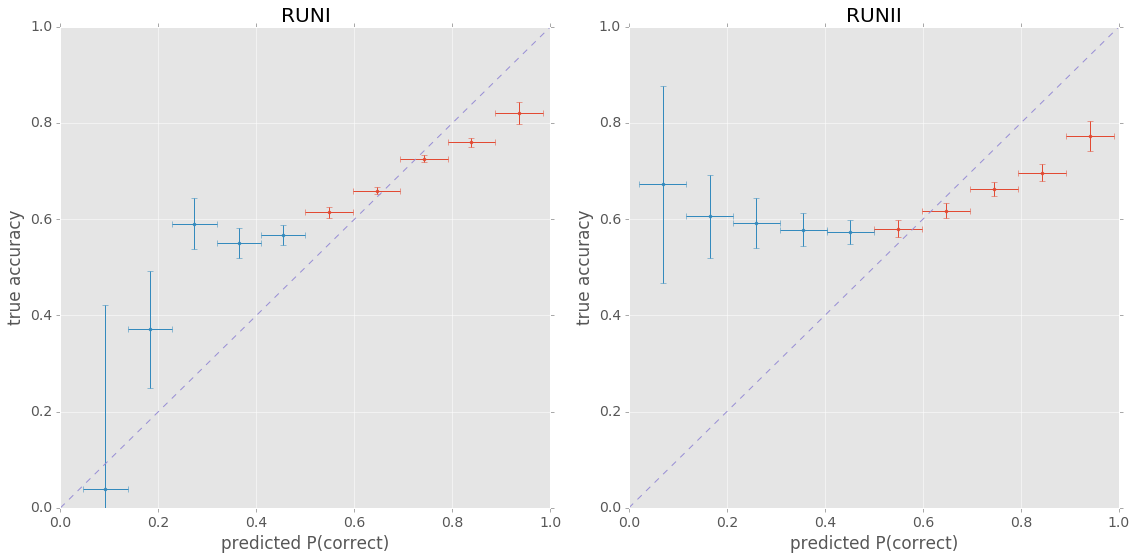

In [24]:
_, axes = plt.subplots(1, 2, figsize=(16, 8))
bins = np.unique(np.concatenate([np.arange(0, 0.3, 0.15),
                                 np.arange(0.3, 0.4, 0.1),
                                 np.arange(0.4, 0.9, 0.05),
                                 [1]]))
for (key, d), ax in zip(datasets.items(), axes):
    plt.axes(ax)
    test_data = d['test_data']
    x = test_data.probas
    y = test_data.target
    plt.errorbar(*proba_bins(x[test_data.prediction], y[test_data.prediction],
                             sample_weight=test_data.SigYield_sw[test_data.prediction],
                             auto_fill=True, bins=5), fmt='.')
    plt.errorbar(*proba_bins(x[~test_data.prediction], y[~test_data.prediction],
                             sample_weight=test_data.SigYield_sw[~test_data.prediction],
                             auto_fill=True, bins=5), fmt='.')
    plt.plot([0, 1], '--')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('predicted P(correct)')
    plt.ylabel('true accuracy')
    plt.title(key)
plt.tight_layout()
plt.show()

In [18]:
for key, d in datasets.items():
    calib_data = d['calib_data']
    test_data = d['test_data']
    
    # polynomial logistic regression
    calibration_model = PolynomialLogisticRegression(power=3, solver='lbfgs', n_jobs=24)
    calibration_model.fit(calib_data.probas.reshape(-1, 1), calib_data.target)
    datasets[key]['logistic_calib_model'] = calibration_model
    
    # isotonic regression
    isotonic_calib_model = IsotonicRegression(y_min=0, y_max=1)
    isotonic_calib_model.fit(calib_data.probas, calib_data.target)
    datasets[key]['isotonic_calib_model'] = isotonic_calib_model
    def model(x):
        return 1 / (1 + np.exp(-x))
    for subset_name in ['train_data', 'test_data', 'calib_data']:
        datasets[key][subset_name]['calib_probas'] = calibration_model.predict_proba(d[subset_name].probas)[:,1]
        datasets[key][subset_name]['isotonic_probas'] = isotonic_calib_model.predict(d[subset_name].probas)

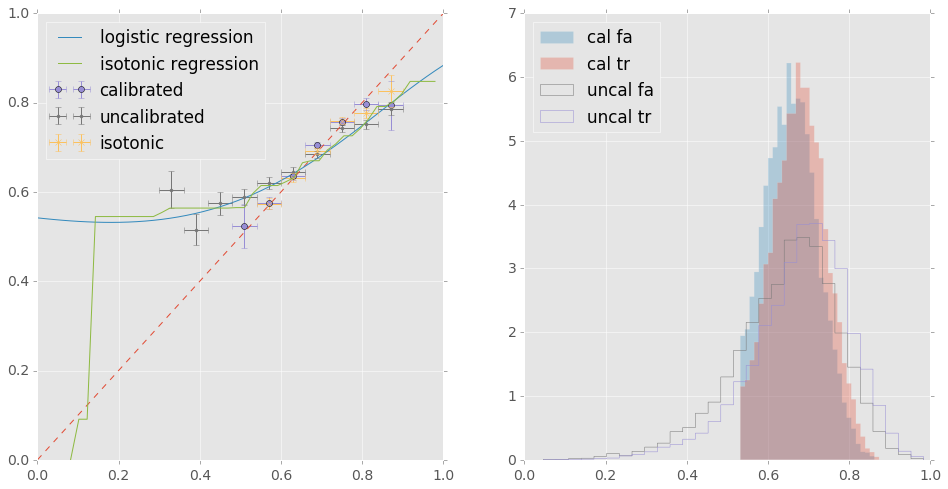

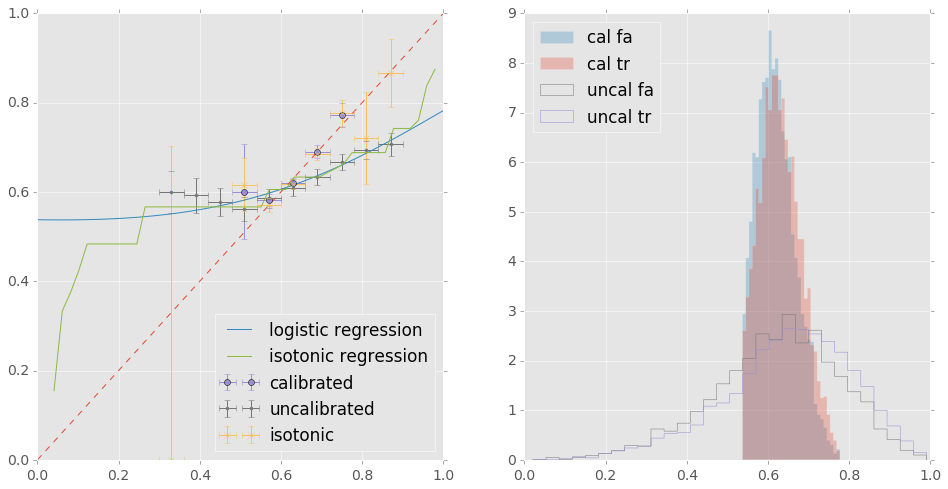

In [19]:
for key, d in datasets.items():
    test_data = d['test_data']
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    plt.plot([0, 1], '--')
    xs = np.linspace(0, 1)
    calibration_model = d['logistic_calib_model']
    plt.plot(xs, calibration_model.predict_proba(xs)[:,1],
             label='logistic regression')
    calib_probas = datasets[key]['test_data'].calib_probas
    plt.errorbar(*proba_bins(calib_probas, test_data.target, sample_weight=test_data.SigYield_sw, range=(0.3, 0.9)),
                 fmt='o', label='calibrated')
    plt.errorbar(*proba_bins(test_data.probas, test_data.target, sample_weight=test_data.SigYield_sw, range=(0.3, 0.9)),
                 fmt='.', label='uncalibrated')
    plt.errorbar(*proba_bins(test_data.isotonic_probas, test_data.target,
                             sample_weight=test_data.SigYield_sw, range=(0.3, 0.9)),
                 fmt='x', label='isotonic')
    plt.plot(xs, d['isotonic_calib_model'].predict(xs), label='isotonic regression')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(loc='best')
    plt.subplot(122)
    plt.hist([calib_probas[test_data.target.values],
              calib_probas[~test_data.target.values],
             ], bins=30, histtype='stepfilled', alpha=0.3, normed=True,
             label=['cal tr',
                    'cal fa',])
    plt.hist([test_data.probas[test_data.target],
              test_data.probas[~test_data.target],
             ], bins=30, histtype='step', normed=True,
             label=['uncal tr',
                    'uncal fa',])
    plt.legend(loc='upper left')
    plt.show()

In [20]:
for key, d in datasets.items():
    test_data = d['test_data']
    eff = datasets[key]['event_number_selected'] / datasets[key]['event_number']
    print(key)
    print(tagging_power_score(test_data.calib_probas,
                              eff, sample_weight=test_data.SigYield_sw) * 100)
    print(tagging_power_score(test_data.probas,
                              eff, sample_weight=test_data.SigYield_sw) * 100)
    print(tagging_power_score(test_data.isotonic_probas,
                              eff, sample_weight=test_data.SigYield_sw) * 100)

RUNI
0.7636+/-0.0032
0.993+/-0.004
0.7730+/-0.0032
RUNII
0.568+/-0.004
1.334+/-0.009
0.592+/-0.004


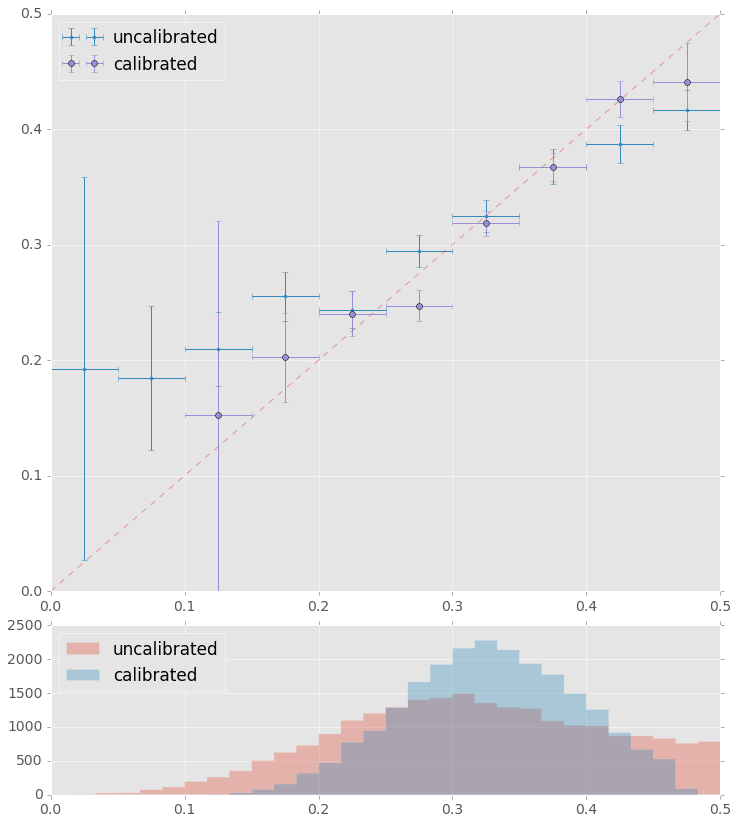

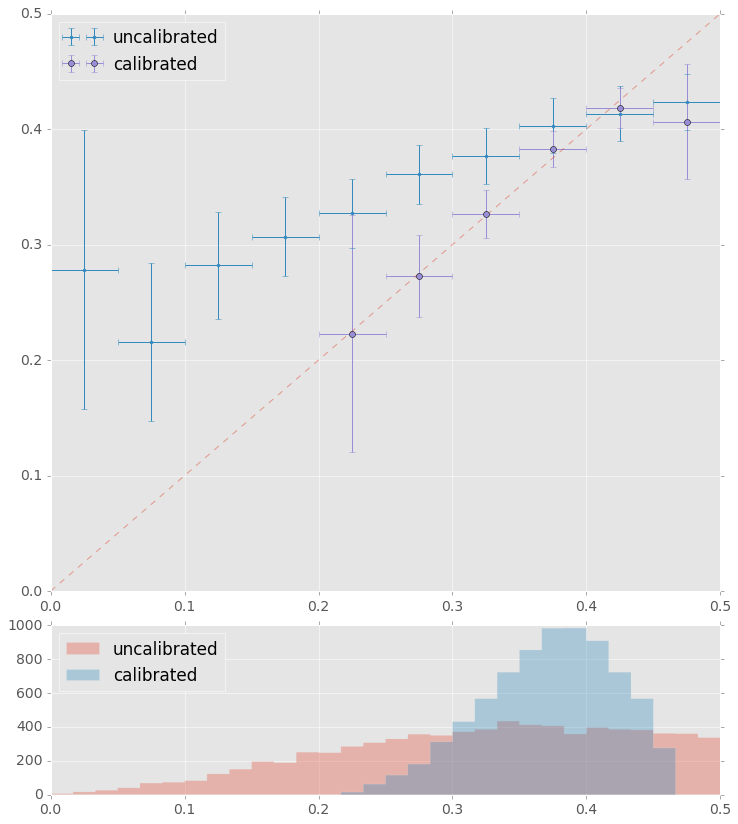

In [21]:
for key, d in datasets.items():
    plt.figure(figsize=(12, 14))
    ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
    ax2 = plt.subplot2grid((4, 1), (3, 0))
    data = d['test_data']
    data['etas'] = np.where(data.probas > 0.5, 1 - data.probas, data.probas)
    data['calib_etas'] = np.where(data.calib_probas > 0.5, 1 - data.calib_probas, data.calib_probas)
    plt.axes(ax1)
    plt.plot([0, 0.5], [0, 0.5], '--', alpha=0.5)
    plt.errorbar(*proba_bins(data.etas, ~data.target, sample_weight=data.SigYield_sw, range=(0, 0.5)),
                 fmt='.', label='uncalibrated')
    plt.errorbar(*proba_bins(data.calib_etas, ~data.target, sample_weight=data.SigYield_sw, range=(0, 0.5)),
                 fmt='o', label='calibrated')
    plt.ylim(0, 0.5)
    plt.legend(loc='best')
    plt.axes(ax2)
    plt.hist(data.etas, bins=30, range=(0, 0.5), alpha=0.33, label='uncalibrated', histtype='stepfilled')
    plt.hist(data.calib_etas, bins=30, range=(0, 0.5), alpha=0.33, label='calibrated', histtype='stepfilled')
    plt.legend(loc='upper left')
    plt.show()

In [1]:
from selection_gridsearch import CutBasedXGBClassifier

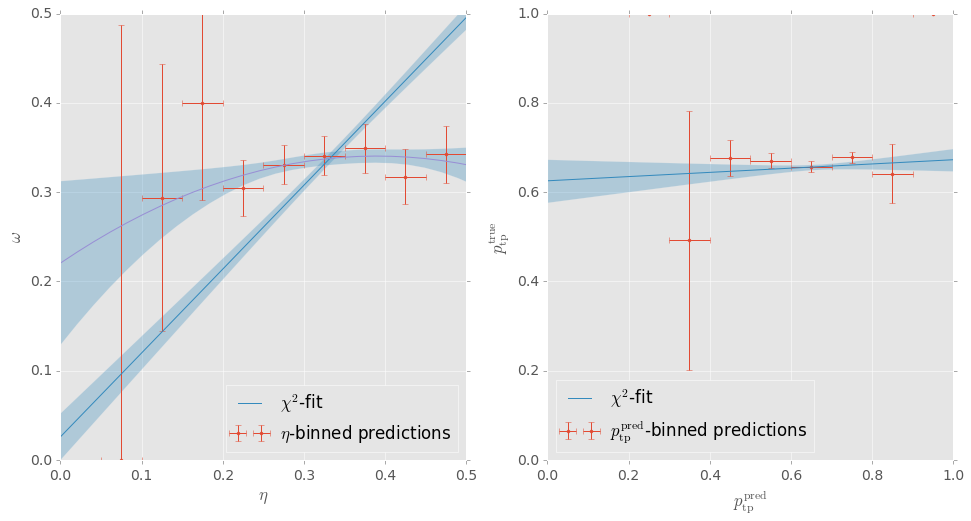

In [854]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.errorbar(*proba_bins(etas, test_labels == False, range=(0, 0.5), sample_weight=test_weights),
             fmt='.', label=r'$\eta$-binned predictions')
xs = np.linspace(0, 1)
plt.plot(xs, omega(xs, *params), label=r'$\chi^2$-fit')
plt.fill_between(xs, 
                 omega_poly(xs, *params) - np.sqrt(d_omega_poly(xs, cov, *params)),
                 omega_poly(xs, *params) + np.sqrt(d_omega_poly(xs, cov, *params)),
                 alpha=0.3)
plt.plot(xs, omega_poly(xs, *params_poly))
plt.fill_between(xs, 
                 omega_poly(xs, *params_poly) - np.sqrt(d_omega_poly(xs, cov_poly, *params_poly)),
                 omega_poly(xs, *params_poly) + np.sqrt(d_omega_poly(xs, cov_poly, *params_poly)),
                 alpha=0.3)
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\omega$')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.errorbar(*proba_bins(probas, test_labels, range=(0, 1), sample_weight=test_weights),
             fmt='.', label=r'$p_\mathrm{tp}^\mathrm{pred}$-binned predictions')
xs = np.linspace(0, 1)
plt.plot(xs, omega(xs, *params_p), label=r'$\chi^2$-fit')
plt.fill_between(xs,
                 omega_poly(xs, *params_p) - np.sqrt(d_omega_poly(xs, cov_p, *params_p)),
                 omega_poly(xs, *params_p) + np.sqrt(d_omega_poly(xs, cov_p, *params_p)),
                 alpha=0.3)
plt.xlabel(r'$p_\mathrm{tp}^\mathrm{pred}$')
plt.ylabel(r'$p_\mathrm{tp}^\mathrm{true}$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='best')
plt.show()

In [25]:
to_root(datasets['RUNI']['max_pt_data'], './data/classic-selection-run1.root')

/home/kheinicke/.anaconda2/lib/python2.7/site-packages/root_numpy/_tree.py:570: UserWarning: converter for dtype('O') is not implemented (skipping)
  _librootnumpy.array2root(arr, filename, treename, mode)


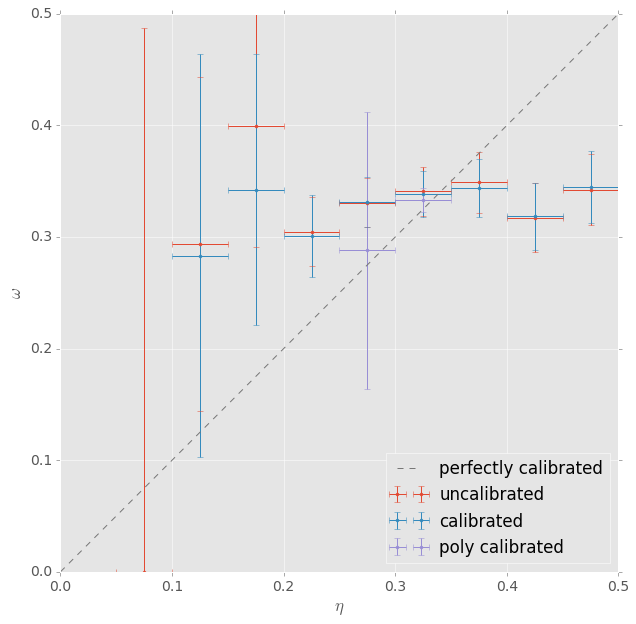

In [855]:
calibrated_etas = omega(etas, *params)
poly_calibrated_etas = omega_poly(etas, *params_poly)
plt.figure(figsize=(10, 10))
plt.errorbar(*proba_bins(etas, test_labels == False, range=(0, 0.5), sample_weight=test_weights),
             fmt='.', label='uncalibrated')
plt.errorbar(*proba_bins(calibrated_etas, test_labels == False, range=(0, 0.5), sample_weight=test_weights),
             fmt='.', label='calibrated')
plt.errorbar(*proba_bins(poly_calibrated_etas, test_labels == False, range=(0, 0.5), sample_weight=test_weights),
             fmt='.', label='poly calibrated')
plt.plot([0, 0.5], [0, 0.5], '--', label='perfectly calibrated')
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)
plt.legend(loc='best')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\omega$')
plt.show()

In [869]:
# tagging power is even worse, obviously the simple linear calibration is not approprate here
tagging_power_score(test_labels, calibrated_etas, 0.5 * get_event_number(df), sample_weight=test_weights) * 100

0.50698604207927889

In [870]:
from scripts.utils import bootstrap_calibrate_prob
D2s, aucs = bootstrap_calibrate_prob(max_pt_data.target, max_pt_data.SigYield_sw,
                                     xgb_model.predict_proba(max_pt_data[classic_MVA_features])[:,1])

In [871]:
np.mean(D2s)

0.16551012368092832

In [872]:
d2_score(poly_calibrated_etas, sample_weight=test_weights)

0.11169968763742212

In [873]:
tagging_power_score(test_labels, etas, 0.5 * get_event_number(df), sample_weight=test_weights) * 100

0.54843754883174334

In [874]:
tagging_power_score(test_labels, poly_calibrated_etas, 0.5 * get_event_number(df), sample_weight=test_weights) * 100

0.46034211890261234